# 시계열 데이터 분석 (정석)

ACF plot과 PACF plot을 통해 모수를 추정하여 차분을 수행하여 분석하는 방법

In [27]:
from pandas import read_excel
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import seaborn as sb
import sys

### 데이터 가져오기

In [28]:
df = read_excel("https://data.hossam.kr/E06/air_passengers.xlsx",index_col='Month')
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## #03. ACF, PACF 검정

정상 시계열 데이터의 경우, ACF는 상대적으로 빠르게 0(상관관계 0)에 접근한다.

비정상 시계열 데이터의 경우, ACF는 천천히 감소하며 종종 큰 양의 값을 갖는다.

> 차분이 필요 없다고 판정되었으므로 원본 데이터로 진행한다.

| 구분 | $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합 |
|---|---|---|
| ACF plot | 천천히 감소 | 첫 값으로부터 $q$개 뒤에 끊긴다. |
| PACF plot | 첫 값으로부터 $p$개 뒤에 끊긴다. | 천천히 감소 |

  

### ACF Plot

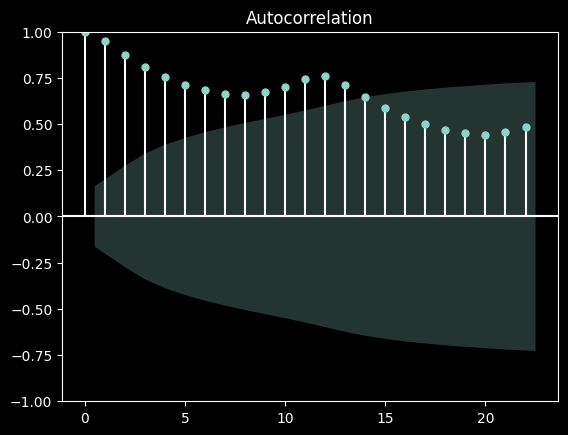

In [29]:
plot_acf(df['Passengers'])
plt.show()
plt.close()

### PACF Plot

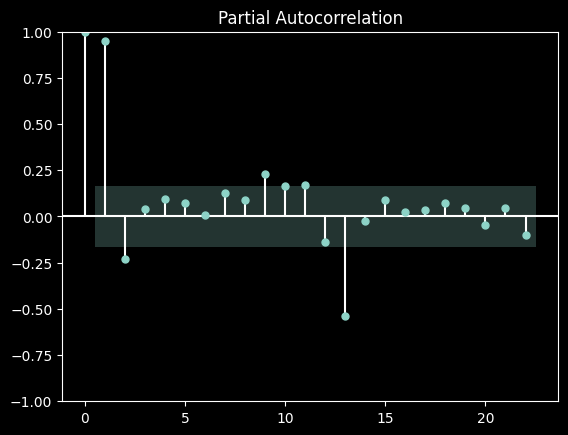

In [30]:
plot_pacf(df['Passengers'])
plt.show()
plt.close()

#### 결과 판정

| 구분 | ACF plot | PACF plot |
|---|---|---|
| 감소 | 상대적으로 완만 | 상대적으로 급격 |
| 파란박스 진입 지점 | $p=1$ | $q=1$ |

이 결과를 고려하여 완만함을 보이는 ACF 플롯을 채택 

$AR(1)$ 모델로 결정

p-value가 0.05보다 작으므로 귀무가설을 기각하도 대립가설 채택. 즉 예제 데이터는 정상성 데이터

만약 귀무가설이 채택되어 정상성이 아니라고 판단될 경우 차분을 1회 수행하고 다시 ADF 검정을 수행

대립가설이 채택될 때 까지 이 과정을 반복함

반복횟수가 $d$ 값이 됨 

> 이 예제에서는 1번의 차분은 수행해야 한다고 가정함

## #03. ARIMA 분석 수행

시계열 데이터를 계절 ARIMA 모델에 맞추려고 할 때 첫 번째 목표는 측정항목을 최적화하는 ARIMA(p,d,q)(P,D,Q)s 값을 찾는 것

In [31]:
# 기본수행 -> order(p,d,q)
model = ARIMA(df['Passengers'],order=(1,2,0))

# 계절성 고려 -> seasonal_order = (P,D,Q,s) 
# 월단위 데이터이므로 1년 주기로 보고 주기는 12로 설정함(분석가가 직접 판단)

model = ARIMA(df['Passengers'], order=(1,2,0), seasonal_order=(1,2,0,12))
fit = model.fit()
print(fit.summary())

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\si

                                    SARIMAX Results                                     
Dep. Variable:                       Passengers   No. Observations:                  144
Model:             ARIMA(1, 2, 0)x(1, 2, 0, 12)   Log Likelihood                -509.419
Date:                          Fri, 04 Aug 2023   AIC                           1024.838
Time:                                  15:34:06   BIC                           1033.150
Sample:                              01-01-1949   HQIC                          1028.213
                                   - 12-01-1960                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6988      0.078     -9.008      0.000      -0.851      -0.547
ar.S.L12      -0.5743      0.087     -6.606      0.

### 학습 결과에 대한 예측값 생성

In [32]:
start_index = 0
end_index = len(df['Passengers'])
pd = fit.predict(start=start_index, end=end_index)
pd

1949-01-01      0.000000
1949-02-01    195.988808
1949-03-01    124.026712
1949-04-01    145.979273
1949-05-01    126.019141
                 ...    
1960-09-01    477.004006
1960-10-01    436.744842
1960-11-01    428.093455
1960-12-01    435.128564
1961-01-01    432.016710
Freq: MS, Name: predicted_mean, Length: 145, dtype: float64

### 이후 10 단계의 예측값 생성

In [33]:
fc = fit.forecast(10)
fc

1961-01-01    432.016710
1961-02-01    395.569595
1961-03-01    404.189553
1961-04-01    459.418748
1961-05-01    455.818546
1961-06-01    499.898325
1961-07-01    589.469959
1961-08-01    547.689220
1961-09-01    438.423581
1961-10-01    376.157403
Freq: MS, Name: predicted_mean, dtype: float64

### 관측치와 예측치의 비교 결과 시각화

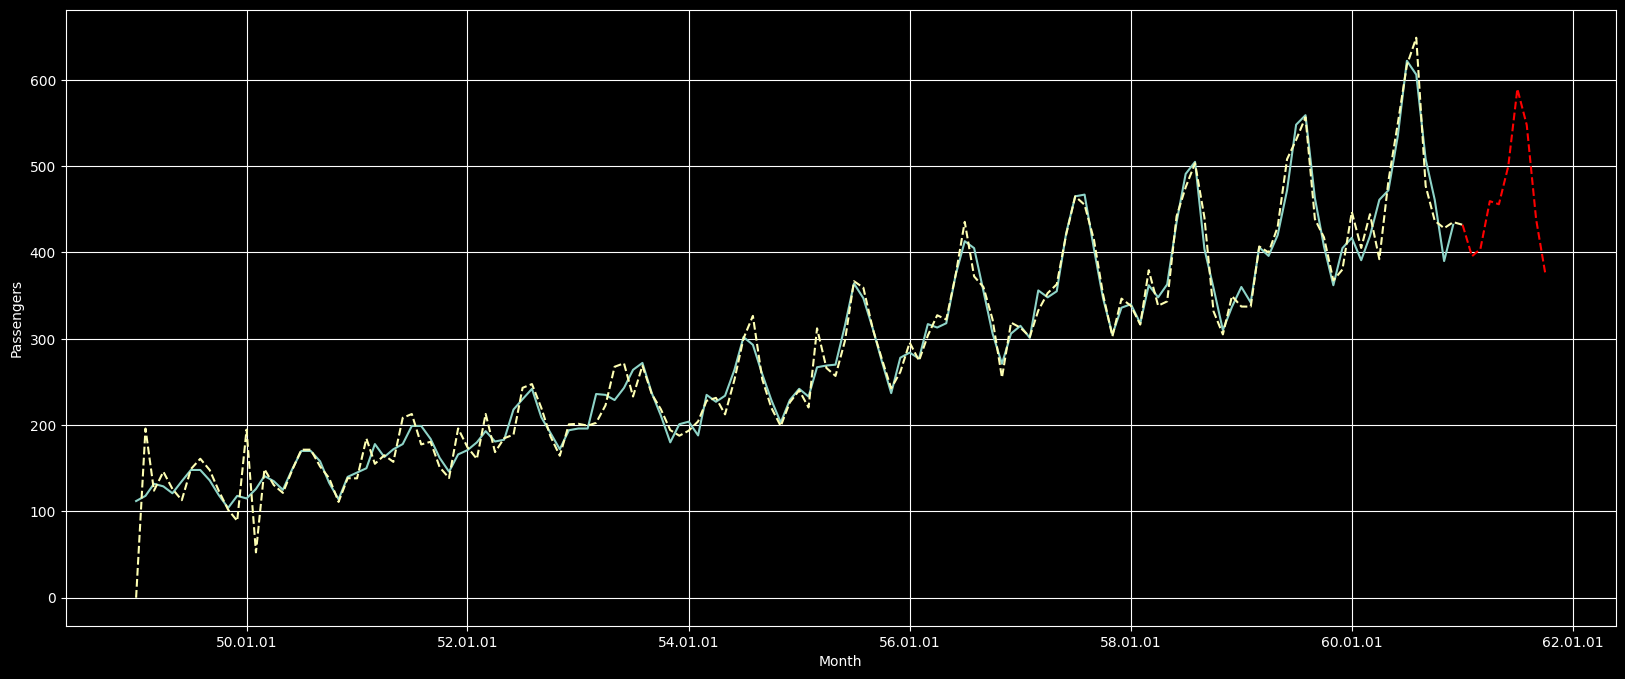

In [35]:
plt.figure(figsize=(20,8))

# 원본
sb.lineplot(x=df.index, y=df['Passengers'])

# 원본을 토대로 학습하여 예측한 값
sb.lineplot(x=pd.index, y=pd, linestyle='--')

# 이후 10단계를 예측한 값
sb.lineplot(x=fc.index, y=fc, linestyle='--', color='red')

plt.xlabel('Month')
plt.ylabel('Passengers')

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

# ----- 이 아래는 오전에 한 것 -------------

In [ ]:
x = list(range(0, len(df), 20))
x

[0, 20, 40, 60, 80, 100, 120, 140]

In [ ]:
xlabels = []

for i in x:
    xlabels.append(df.loc[i, 'Month'].strftime('%Y-%m-%d'))

xlabels

['1949-01-01',
 '1950-09-01',
 '1952-05-01',
 '1954-01-01',
 '1955-09-01',
 '1957-05-01',
 '1959-01-01',
 '1960-09-01']

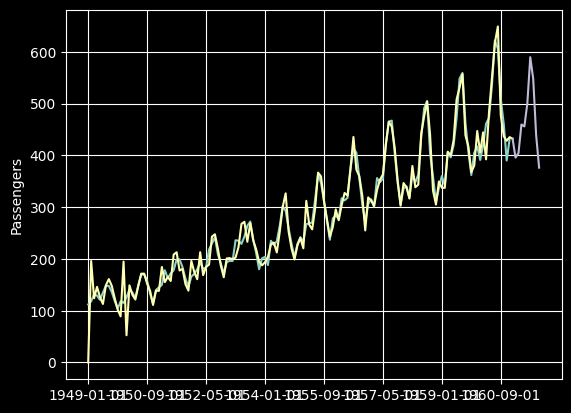

In [ ]:
plt.figure()
sb.lineplot(x=df.index, y=df['Passengers']) # 원본
sb.lineplot(x=pd.index, y=pd)           # 원본을 토대로 학습하여 예측한 값
sb.lineplot(x=fc.index, y=fc)           # 이후 10단계를 예측한 값

plt.xticks(x, xlabels, rotation=0)

plt.grid()
plt.show()
plt.close()